# differences between putative inhibitory and pyramidal neurons

mainly focusing on differences in STRFs and Tuning Curves


In [69]:
from joblib import Memory, dump, Parallel, delayed
import pathlib as pl
from src.root_path import root_path
from src.visualization.fancy_plots import subplots_sqr
from configparser import ConfigParser
import numpy as np
from scipy import ndimage as ndi
from collections import defaultdict
import math

import matplotlib.pyplot as plt

from nems_lbhb.baphy_experiment import BAPHYExperiment
from nems_lbhb.celldb import get_single_cell_data, update_single_cell_data
from nems_lbhb.strf.strf import tor_tuning
from nems_lbhb.strf.torc_subfunctions import strfplot, interpft

In [ ]:
config = ConfigParser()
config.read_file(open(root_path / 'config/settings.ini'))


In [16]:
# list of good torc files with know phototagging
# CPN sorting sets
torc_files = ['/auto/data/daq/Teonancatl/TNC014/TNC014a08_p_TOR.m',
              '/auto/data/daq/Teonancatl/TNC015/TNC015a09_p_TOR.m',
              '/auto/data/daq/Teonancatl/TNC017/TNC017a13_p_TOR.m',
              '/auto/data/daq/Teonancatl/TNC018/TNC018a15_p_TOR.m']


# TOR and FTC sorting sets
torc_files = ['/auto/data/daq/Teonancatl/TNC015/TNC015a19_p_TOR.m',
              '/auto/data/daq/Teonancatl/TNC016/TNC016a19_p_TOR.m',
              '/auto/data/daq/Teonancatl/TNC017/TNC017a19_p_TOR.m',
              '/auto/data/daq/Teonancatl/TNC018/TNC018a22_p_TOR.m',
              '/auto/data/daq/Teonancatl/TNC019/TNC019a18_p_TOR.m']

ftc_files = ['/auto/data/daq/Teonancatl/TNC014/TNC014a19_p_FTC.m',
             '/auto/data/daq/Teonancatl/TNC015/TNC015a20_p_FTC.m'
             '/auto/data/daq/Teonancatl/TNC016/TNC016a20_p_FTC.m',
             '/auto/data/daq/Teonancatl/TNC017/TNC017a21_p_FTC.m',
             '/auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m',
             '/auto/data/daq/Teonancatl/TNC019/TNC019a20_p_FTC.m'
             ]

calculates and caches STRF and extra data

In [42]:
memory = Memory(str(pl.Path(config['paths']['analysis_cache']) / 'STRF'))

tor_tuning_cached = memory.cache(tor_tuning)

all_strfs = list()
all_neurons = list()

for tf in torc_files:

    expt = BAPHYExperiment(parmfile=tf)
    options = {'resp': True, 'rasterfs': 1000, 'stim':False}
    rec = expt.generate_recording(recache=False, **options)
    cellids = rec['resp'].chans

    # bundles togethere torc calculation and tag import
    def tor_n_tag(neuron, rec):
        nDF = get_single_cell_data(neuron)

        try:
            tag = nDF.phototag[0]
        except:
            print(f'{neuron} undefined phototag, defaulting to n')
            tag = 'n'

        strf = tor_tuning_cached(neuron, rec=rec, plot=False)

        return strf, tag

    site_strf = Parallel(n_jobs=4)(
                           delayed(tor_n_tag)(neuron, rec=rec)
                           for neuron in cellids)
    all_strfs.extend(site_strf)
    all_neurons.extend(cellids)

[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC015/TNC015a19_p_TOR.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC015/TNC015a19_p_TOR.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC015/TNC015a19_p_TOR.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC015/TNC015a19_p_TOR.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 60 trials totaling 192.60 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC015/TNC015a19_p_TOR.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC015/TNC015a19_p_TOR.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb

## Oganize data in arrays with dim0 = Neuron.

stacked STRFs shape: (349, 15, 13), Neuron x Freq x Time


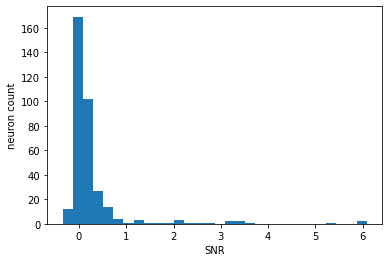

In [78]:
stacked_strfs = np.stack([strf_meta[0].STRF for strf_meta in all_strfs],axis=0)
print(f'stacked STRFs shape: {stacked_strfs.shape}, Neuron x Freq x Time')

opto_tags = np.asarray([strf_meta[1] for strf_meta in all_strfs])
all_neurons = np.asarray(all_neurons)
all_snr = np.asarray([strf_meta[0].Signal_to_Noise for strf_meta in all_strfs])

fig, ax  = plt.subplots()
_ = ax.hist(all_snr, bins=30)
_ = ax.set_xlabel('SNR')
_ = ax.set_ylabel('neuron count')
plt.show()

## Smooths STRFs

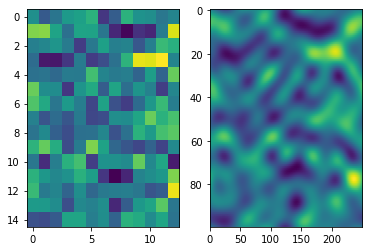

In [59]:
Nd, Fd, Td = stacked_strfs.shape
itp_freq, itp_time = 100, 250
smooth_strfs = np.empty([Nd, itp_freq, itp_time]) # arbitrary value for consistency with matlab strf

for nn, strf in enumerate(stacked_strfs):
    smooth_strfs[nn, ...] = interpft(interpft(strf, itp_freq, 0), itp_time, 1)

fig, [raw, smooth] = plt.subplots(1,2)
raw.imshow(stacked_strfs[0,...], aspect='auto')
smooth.imshow(smooth_strfs[0,...], aspect='auto')
plt.show()

## STRFs
selected by SNR and discriminates by tag

In [62]:
snr_mask = all_snr > 0.2
pyr_mask = opto_tags == 's'
inh_mask = opto_tags == 'a'


In [98]:
# defines extra ploting parameters and snr sorted STRF ploting
noct = all_strfs[0][0].StimParams['octaves']
tlen = all_strfs[0][0].StimParams['basep']
extent = [0, tlen, 0, noct]

def STRF_tiling(STRFs, sharemap=False, **kwargs):

    fig, axes = subplots_sqr(len(STRFs), sharey=True, sharex=True, **kwargs)
    axes= np.ravel(axes)
    for ax, arr in zip(axes, STRFs):
        if sharemap:
            vmin, vmax = STRFs.min(), STRFs.max()
            _ = ax.imshow(arr, aspect='auto', extent=extent, origin='lower', vmin=vmin, vmax=vmax, **kwargs)
        else:
            _ = ax.imshow(arr, aspect='auto', extent=extent, origin='lower', **kwargs)


    for ax in axes:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    fig.tight_layout(h_pad= 0.01, w_pad=0.01)
    return fig, axes


### inhibitory interneurons

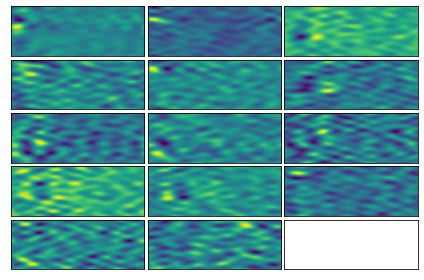

In [104]:
mask = np.logical_and(inh_mask, snr_mask)
order = np.argsort(all_snr[mask])[::-1]

fig, axes = STRF_tiling(smooth_strfs[mask][order], sharemap=False)

### pyramidal neurons

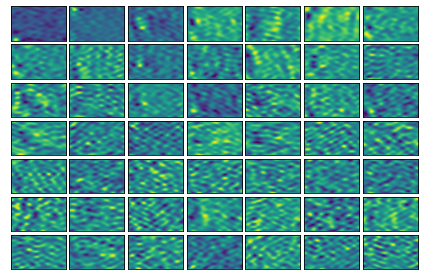

In [103]:
mask = np.logical_and(pyr_mask, snr_mask)
order = np.argsort(all_snr[mask])[::-1]

fig, axes = STRF_tiling(smooth_strfs[mask][order], sharemap=False)

## STRF component
across all neurons

In [189]:
def plot_components_with_mean(time_comps, freq_comps, **kwargs):

    def plot_with_mean(tser, ax, **kwargs):
        _ = ax.plot(tser.T, alpha=0.1, color='gray', **kwargs)
        _ = ax.plot(np.nanmean(tser, axis=0), alpha=1, color='black', **kwargs)
        return ax

    fig, (time_ax, freq_ax)  = plt.subplots(1,2)

    _ = plot_with_mean(time_comps, time_ax, **kwargs)
    _ = plot_with_mean(freq_comps, freq_ax, **kwargs)

    time_ax.set_title('temporal components')
    freq_ax.set_title('frequency components')

    return fig, [time_ax, freq_ax]


### raw components

In [165]:
# calculates temporal and frequency top components
time_comp = np.empty((Nd, itp_time))
freq_comp = np.empty((Nd, itp_freq))
for ii, strf in enumerate(smooth_strfs):
    [u, s, v] = np.linalg.svd(strf)
    time_comp[ii,:] = v[0, :]
    freq_comp[ii,:] = u[:, 0]

# flip components to match orientation
time_flip_mask = np.abs(np.min(time_comp, axis=1)) > np.max(time_comp, axis=1)
time_comp[time_flip_mask] = time_comp[time_flip_mask] * -1

freq_flip_mask = np.abs(np.min(freq_comp, axis=1)) > np.max(freq_comp, axis=1)
freq_comp[freq_flip_mask] = freq_comp[freq_flip_mask] * -1

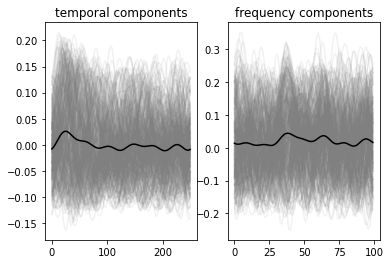

In [167]:
fig, axes = plot_components_with_mean(time_comp, freq_comp)
fig.suptitle('raw STRF components')

### centered components

In [187]:
# center components at maximum
# temporal component
# time_comp0 = np.full((Nd, itp_time*2), np.nan)
time_comp0 = np.zeros((Nd, itp_time*2))
for ii, tc in enumerate(time_comp):
    start = int(itp_time - np.argmax(tc))
    end = int(start + itp_time)
    time_comp0[ii, start:end] = tc

# frequency component
# freq_comp0 = np.full((Nd, itp_freq*2), np.nan)
freq_comp0 = np.zeros((Nd, itp_freq*2))
for ii, fc in enumerate(freq_comp):
    start = int(itp_freq - np.argmax(fc))
    end = int(start + itp_freq)
    freq_comp0[ii, start:end] = fc

Text(0.5, 0.98, 'centered STRF components')

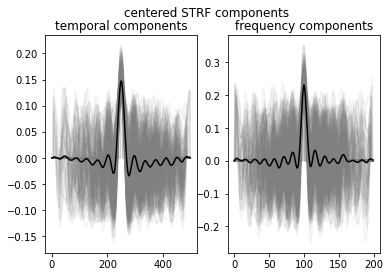

In [190]:
fig, axes = plot_components_with_mean(time_comp0, freq_comp0)
fig.suptitle('centered STRF components')

### components filtered by SNR and discriminated by tag

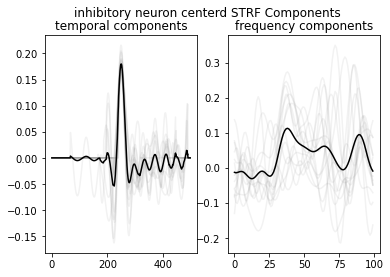

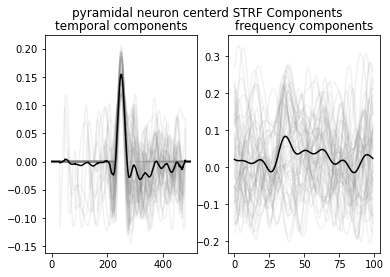

In [191]:
masks = [inh_mask, pyr_mask]
celltypes = ['inhibitory', 'pyramidal']

for tmask, ctype in zip(masks, celltypes):

    mask = np.logical_and(snr_mask, tmask)

    tcomps = time_comp0[mask]
    fcomps = freq_comp[mask]
    fig, axes = plot_components_with_mean(tcomps, fcomps)
    fig.suptitle(f'{ctype} neuron centerd STRF Components')
